## Teste de Ciências de Dados - Cadastra
### Etapa 3 - Modelagem e Avaliação (Retirando variáveis de vazameto e informação

### Autor: Leonardo Padilha de Lima
#### (15) 99738-3447
#### leo.plima08@gmail.com

 https://github.com/leoplima/desafio_cadastra


### 1)	Importação das bibliotecas necessárias

In [1]:
# importação de pacotes básico

import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

import warnings


%matplotlib inline

warnings.filterwarnings("ignore")

### 2)	Importação das bases de dados fornecidas usando o Pandas e mostrando as cinco primeiras linhas do conjunto de dados.

In [2]:
# importando base de dados

def importar_base():
    '''
    Função que vai importar a base e transformar em uma DataFrame pandas.
    '''
    try:
    
        df = pd.read_csv('base_eda.csv', sep = ',')
        df = df.sort_values('COD_CICLO').reset_index(drop=True)
    
    except Exception as erro:
        print(f'Opa! Um problema de {erro.__class__} foi encontrato.')
    
    return df

In [3]:
df = importar_base()
df.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO
0,201801,0,443142,anon_S0,anon_S5,anon_S20,anon_S10,10068.0,294.0,294270.60,281610.18,0,1,0,0,0,10.0,413.4
1,201801,0,147546,anon_S7,anon_S5,anon_S34,anon_S1,240.0,NaN,413.40,413.40,0,0,0,0,0,NaN,413.4
2,201801,0,420630,anon_S7,anon_S5,anon_S34,anon_S10,2388.0,NaN,43003.08,43003.08,0,1,0,0,0,10.0,353.4
3,201801,0,170454,anon_S7,anon_S5,anon_S24,anon_S10,3516.0,NaN,61451.04,61451.04,0,0,0,0,0,NaN,347.4
4,201801,0,152700,anon_S0,anon_S12,anon_S34,anon_S10,29670.0,1266.0,2352170.40,2210035.02,0,1,0,0,0,10.0,713.4


### 3)	Préprocessamento

#### 3.1) Definir as variáveis preditoras (X) e alvo (y)

In [4]:
X = df.drop(columns=['QT_VENDA_BRUTO','VL_RECEITA_BRUTA', 'VL_RECEITA_LIQUIDA'])
y = df['QT_VENDA_BRUTO']

#### 3.2) Separar em conjunto de treino e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 78)

#### 3.3) Identificar as variáveis para tratamento específicos

In [6]:
# Vamos fazer tratamentos específicos nas variáveis categóricas e numéricas

onehot_encoded = ['COD_CANAL', 'DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL', 'COD_REGIAO']
imputer = ['QT_DEVOLUCAO','PCT_DESCONTO']
sc = ['QT_DEVOLUCAO','PCT_DESCONTO','VL_PRECO']

#### 3.4) Criando os pipeline de pré-processamento

In [7]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))  # Codifica variáveis categóricas
])

int_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)) # Imputa valores com zero
])

scaler = Pipeline(steps=[
    ('scaler', StandardScaler()) # realiza o escalonamento
])

#### 3.5) Criando o transformer para os pipelines

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, onehot_encoded),
        ('imp', int_transformer, imputer),
        ('sca', scaler, sc)
    ])

### 4) Executando pipeline e treinando modelo (base)

In [9]:
# Treinar o modelo base
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state = 78))
])

pipeline_base.fit(X_train, y_train)

# AVALIANDO MODELO DE TREINO
y_pred_treino = pipeline_base.predict(X_train)

rmse_treino = mean_squared_error(y_train, y_pred_treino, squared = False)  # RMSE
mape_treino = mean_absolute_percentage_error(y_train, y_pred_treino)  # MAPE
mae_treino = mean_absolute_error(y_train, y_pred_treino) #MAE
r2_treino = r2_score(y_train, y_pred_treino) #R2

print(f"Modelo Base - RMSE: {rmse_treino}, MAPE: {mape_treino}, MAE:{mae_treino}, R2: {r2_treino}")
print(f"Mediana do Preço: {df['QT_VENDA_BRUTO'].median()}")


Modelo Base - RMSE: 21209.342674774893, MAPE: 3.1786962505331875, MAE:6462.916824161538, R2: 0.5807173697624043
Mediana do Preço: 2070.0


### 5) Avaliação do modelo base usando métricas RMSE e MAPE, MAE

In [10]:
# Previsões do modelo base
y_pred_base = pipeline_base.predict(X_test)

rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)  # RMSE
mape_base = mean_absolute_percentage_error(y_test, y_pred_base)  # MAPE
mae_base = mean_absolute_error(y_test, y_pred_base) #MAE
r2_base = r2_score(y_test, y_pred_base) #R2

print(f"Modelo Base - RMSE: {rmse_base}, MAPE: {mape_base}, MAE:{mae_base}, R2: {r2_base}")
print(f"Mediana do Preço: {df['QT_VENDA_BRUTO'].median()}")

Modelo Base - RMSE: 26828.936662948658, MAPE: 3.297363654688667, MAE:7046.728082598782, R2: 0.42175097570500686
Mediana do Preço: 2070.0


### 6) Visualizando as variáveis que possuem mais importancia para o modelo

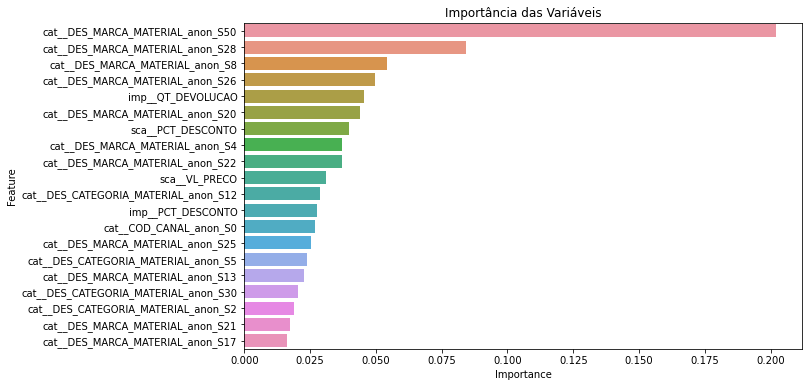

In [11]:
# Extraindo as importâncias das variáveis
model = pipeline_base.named_steps['model']

importances = model.feature_importances_

feature_names = pipeline_base.named_steps['preprocessor'].get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenando as features pela importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotar as importâncias das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))  # Mostrar as 20 mais importantes
plt.title('Importância das Variáveis')
plt.show()

### 7) Otimizando o modelo com seleção de variáveis baseada na importância

In [12]:
# Treinar o modelo base
pipeline_base_selection = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(xgb.XGBRegressor(random_state=78))),
    ('model', xgb.XGBRegressor(random_state=78))
])

pipeline_base_selection.fit(X_train, y_train)

# AVALIANDO MODELO DE TREINO
y_pred_treino = pipeline_base.predict(X_train)

rmse_treino = mean_squared_error(y_train, y_pred_treino, squared=False)  # RMSE
mape_treino = mean_absolute_percentage_error(y_train, y_pred_treino)  # MAPE
mae_treino = mean_absolute_error(y_train, y_pred_treino) #MAE
r2_treino = r2_score(y_train, y_pred_treino) #R2

print(f"Modelo Base - RMSE: {rmse_treino}, MAPE: {mape_treino}, MAE:{mae_treino}, R2: {r2_treino}")
print(f"Mediana do Preço: {df['QT_VENDA_BRUTO'].median()}")

Modelo Base - RMSE: 21209.342674774893, MAPE: 3.1786962505331875, MAE:6462.916824161538, R2: 0.5807173697624043
Mediana do Preço: 2070.0


### 8) Avaliação do modelo com seleção de variáveis usando métricas RMSE e MAPE, MAE

In [13]:
# Previsões do modelo base
y_pred_base_selection = pipeline_base_selection.predict(X_test)

rmse_base_selection = mean_squared_error(y_test, y_pred_base_selection, squared=False)  # RMSE
mape_base_selection = mean_absolute_percentage_error(y_test, y_pred_base_selection)  # MAPE
mae_base_selection = mean_absolute_error(y_test, y_pred_base_selection) #MAE
r2_base_selection = r2_score(y_test, y_pred_base_selection) #R2

print(f"Modelo Base - RMSE: {rmse_base_selection}, MAPE: {mape_base_selection}, MAE:{mae_base_selection}, R2:{r2_base_selection}")
print(f"Mediana do Preço: {df['QT_VENDA_BRUTO'].median()}")

Modelo Base - RMSE: 26998.85985340951, MAPE: 3.2666776687680823, MAE:7090.63712374248, R2:0.4144030079137372
Mediana do Preço: 2070.0


### 9) Otimizando o modelo base com RandomizedSearchCV

In [14]:
# Treinar o modelo otimizado com RandomizedSearchCV
pipeline_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=78))
])

# Espaço de busca dos hiperparâmetros
param_dist = {
    'model__objective':['reg:squarederror'],
    'model__booster':['gbtree','gblinear'],
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.1, 0.3, 0.9, 1],
    'model__max_depth': [3, 5, 7, 9, 10],
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__subsample': [0.6, 0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.3, 0.4],
    'model__reg_alpha': [0.01, 0.1, 1, 10],
    'model__reg_lambda': [0.1, 1, 10]
}

# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_optimized,
    param_distributions=param_dist,
    n_iter = 5,
    cv = 5,
    random_state = 78,
    n_jobs = -1
)
random_search.fit(X_train, y_train)

# AVALIANDO MODELO DE TREINO
y_pred_treino_ran = random_search.predict(X_train)

rmse_treino = mean_squared_error(y_train, y_pred_treino_ran, squared=False)  # RMSE
mape_treino = mean_absolute_percentage_error(y_train, y_pred_treino_ran)  # MAPE
mae_treino = mean_absolute_error(y_train, y_pred_treino_ran) #MAE
r2_treino = r2_score(y_train, y_pred_treino_ran) #MAE

print(f"Modelo Base - RMSE: {rmse_treino}, MAPE: {mape_treino}, MAE:{mae_treino}, R2: {r2_treino}")
print(f"Mediana do Preço: {df['QT_VENDA_BRUTO'].median()}")



Modelo Base - RMSE: 20883.79021837017, MAPE: 2.954745892664071, MAE:6213.223794537093, R2: 0.5934901276563194
Mediana do Preço: 2070.0


### 10) Avaliação do modelo com seleção de variáveis usando métricas RMSE e MAPE, MAE

In [15]:
# Avaliação do modelo otimizado usando RMSE e MAPE

y_pred_optimized = random_search.predict(X_test)

rmse_optimized = mean_squared_error(y_test, y_pred_optimized, squared=False)  # RMSE
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)  # MAPE
mae_optimized = mean_absolute_error(y_test, y_pred_optimized) #MAE
r2_optimized = r2_score(y_test, y_pred_optimized) #MAE

# 8. Comparação entre os modelos

print(f"Modelo Otimizado - RMSE: {rmse_optimized}, MAPE: {mape_optimized}, MAE: {mae_optimized}, R2:{r2_optimized}")

Modelo Otimizado - RMSE: 26842.03102671245, MAPE: 3.0569696977741, MAE: 6827.84131527955, R2:0.42118638748108284


### 11) Otimizando o modelo com seleção de variáveis e RandomizedSearchCV

In [16]:

# 7. Treinar o modelo otimizado com RandomizedSearchCV
pipeline_optimized2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(xgb.XGBRegressor(random_state=78))),
    ('model', xgb.XGBRegressor(random_state=78))
])

# Espaço de busca dos hiperparâmetros
param_dist = {
    'model__objective':['reg:squarederror'],
    'model__booster':['gbtree','gblinear'],
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.1, 0.3, 0.9, 1],
    'model__max_depth': [3, 5, 7, 9, 10],
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__subsample': [0.6, 0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.3, 0.4],
    'model__reg_alpha': [0.01, 0.1, 1, 10],
    'model__reg_lambda': [0.1, 1, 10]
}

# Configuração do RandomizedSearchCV
random_search2 = RandomizedSearchCV(
    pipeline_optimized2,
    param_distributions=param_dist,
    n_iter = 5,
    cv = 5,
    random_state = 78,
    n_jobs = -1
)
random_search2.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['COD_CANAL',
                                                                                'DES_CATEGORIA_MATERIAL',
                                                                                'DES_MARCA_MATERIAL',
                                                                                'COD_REGIAO']),
                                                                              ('imp',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant'))]),
                                                                               ['QT_DEVOLUCAO',
                                                                                'P...
                                        'model__colsample_bytree': [0.6, 0.9,
                                                                    1.0],
                                        'model__gamma': [0, 0.1, 0.3, 0.4],
                                        'model__learning_rate': [0.1, 0.3, 0.9,
                                                                 1],
                                        'model__max_depth': [3, 5, 7, 9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5],
                                        'model__n_estimators': [100, 300, 500],
                                        'model__objective': ['reg:squarederror'],
                                        'model__reg_alpha': [0.01, 0.1, 1, 10],
                                        'model__reg_lambda': [0.1, 1, 10],
                                        'model__subsample': [0.6, 0.7, 0.9,
                                                             1.0]},
                   random_state=78)

### 12) Avaliação final e comparação entre os modelos

In [17]:
# 8. Comparação entre os modelos

y_pred_optimized2 = random_search2.predict(X_test)

# Avaliação do modelo otimizado usando RMSE e MAPE
rmse_optimized2 = mean_squared_error(y_test, y_pred_optimized2, squared=False)  # RMSE
mape_optimized2 = mean_absolute_percentage_error(y_test, y_pred_optimized2)  # MAPE
mae_optimized2 = mean_absolute_error(y_test, y_pred_optimized2) #MAE
r2_optimized2 = r2_score(y_test, y_pred_optimized2) #MAE

print("Comparação entre os Modelos:")
print(f"Modelo Base - RMSE: {rmse_base}, MAPE: {mape_base},  MAE:{mae_base}, R2:{r2_base}")
print(f"Modelo Base Selecion - RMSE: {rmse_base_selection}, MAPE: {mape_base_selection}, MAE:{mae_base_selection}, R2:{r2_base_selection}")
print(f"Modelo Otimizado - RMSE: {rmse_optimized}, MAPE: {mape_optimized}, MAE: {mae_optimized}, R2: {r2_optimized}")
print(f"Modelo Otimizado Selection - RMSE: {rmse_optimized2}, MAPE: {mape_optimized2}, MAE: {mae_optimized2}, R2:{r2_optimized2}")

Comparação entre os Modelos:
Modelo Base - RMSE: 26828.936662948658, MAPE: 3.297363654688667,  MAE:7046.728082598782, R2:0.42175097570500686
Modelo Base Selecion - RMSE: 26998.85985340951, MAPE: 3.2666776687680823, MAE:7090.63712374248, R2:0.4144030079137372
Modelo Otimizado - RMSE: 26842.03102671245, MAPE: 3.0569696977741, MAE: 6827.84131527955, R2: 0.42118638748108284
Modelo Otimizado Selection - RMSE: 27072.64847022533, MAPE: 3.1363299727217577, MAE: 6974.141687684488, R2:0.411197728884944


### O Ganhador é o modelo base.